## 4. Q-learningとSARSA
更新式
$$Q(s,a) \leftarrow Q(s,a) + \alpha (G_t - Q(s,a))$$
モンテカルロ法:
$$G_t = r_{t+1} + \gamma r_{t+2} + \gamma^2 r_{t+3} + \cdots + \gamma^{T-t-1} r_T$$
Q-learning:
$$G_t = r_{t+1} + \gamma \max_a [Q(s_{t+1},a)]$$
SARSA(State-Action-Reward-State-Action):
$$G_t = r_{t+1} + \gamma Q(s_{t+1},a_{t+1})$$
ただし、
$$a_{t+1} = \pi(s_{t+1})$$
$\pi$はpolicy

In [9]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class Agent:
    def __init__(self, env):
        self.env = env
        self.Q = {}
        self.initialize()
        self.reward_log = []
    
    # Q値（各状態における各行動の価値）を初期化
    def initialize(self):
        for s in range(self.env.nS):
            self.Q[s] = [0] * self.env.nA
        self.env.reset()
    
    def policy(self, s, epsilon=0.1):
        if np.random.random() < 0.1:
            return np.random.randint(self.env.nA)
        else:
            if sum(self.Q[s]) == 0:
                return np.random.randint(self.env.nA)
            else:
                return np.argmax(self.Q[s])
    
    # モンテカルロ法実行フェーズ
    def montecarlo(self, episode_count=1000, gamma=0.9, alpha=0.8):
        # エピソードの反復
        for e in range(episode_count):
            done = False
            experience_log = []
            s = 0
            self.env.reset()
            
            # エピソードを実行→エピソードの終了まで実行
            while not done:
                # policyに従って行動する
                a = self.policy(s)
                # 行動を実行して、次の状態:next_s、報酬:reward、終了したかどうか:doneを取得する
                next_s, reward, done, _ = self.env.step(a)
                #　「現在の状態」から「ある行動」をとったときの「価値」と「次の状態」をログとして保存する
                experience_log.append({'state':s, 'action':a, 'reward':reward, 'next_state':next_s})
                s = next_s
            else:
                self.reward_log.append(reward)
            
            # エピソードで取得したログからQ値を更新
            for t, experience in enumerate(experience_log):
                G = 0
                i = 0
                # エピソードでt回目にいた状態、行動の組み合わせにおける割引現在価値を計算
                s = experience['state']
                a = experience['action']
                for j in range(t, len(experience_log)):
                    G += (gamma**i) * experience_log[j]['reward']
                    i += 1
                # Q値の更新
                self.Q[s][a] += alpha * (G - self.Q[s][a])
        #return self.Q
        #return self.reward_log
    
    # Q-learning実行フェーズ
    def q_learning(self, episode_count=1000, gamma=0.9, alpha=0.8):
        # エピソードの反復
        for e in range(episode_count):
            self.env.reset()
            done = False
            s = 0
            self.env.reset()
            
            # エピソードを実行→エピソードの終了まで実行
            while not done:
                # policyに従って行動する
                a = self.policy(s)
                # 行動を実行して、次の状態:next_s、報酬:reward、終了したかどうか:doneを取得する
                next_s, reward, done, _ = self.env.step(a)
                
                G = reward + gamma * np.max(self.Q[next_s])
                # Q値の更新
                self.Q[s][a] += alpha * (G - self.Q[s][a])
                
                s = next_s
            else:
                self.reward_log.append(reward)
            
    # SARSA実行フェーズ
    def sarsa(self, episode_count=1000, gamma=0.9, alpha=0.8):
        # エピソードの反復
        for e in range(episode_count):
            self.env.reset()
            done = False
            s = 0
            self.env.reset()
            
            # policyに従って行動する
            a = self.policy(s)
            
            # エピソードを実行→エピソードの終了まで実行
            while not done:
                # 行動を実行して、次の状態:next_s、報酬:reward、終了したかどうか:doneを取得する
                next_s, reward, done, _ = self.env.step(a)
                
                # 価値算出のために次の状態における行動を決めておく
                next_a = self.policy(next_s)
                
                G = reward + gamma * self.Q[next_s][next_a]
                # Q値の更新
                self.Q[s][a] += alpha * (G - self.Q[s][a])
                
                s = next_s
                a = next_a
            else:
                self.reward_log.append(reward)    
    def show_reward(self, interval=50):
        average_reward = []
        for e in range(0, len(self.reward_log), interval):
            average_reward.append(np.mean(self.reward_log[e:e+interval]))
        return pd.Series(average_reward).plot()

In [7]:
import gym

env = gym.make('FrozenLake-v0', is_slippery=False)
env.render()


SFFF
FHFH
FFFH
HFFG


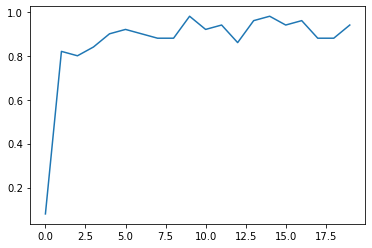

In [8]:
agent = Agent(env)
agent.q_learning()
agent.show_reward()

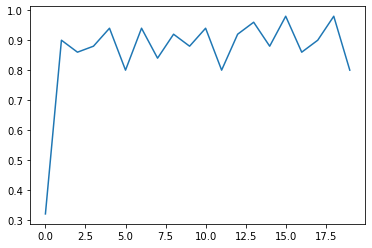

In [11]:
agent = Agent(env)
agent.sarsa()
agent.show_reward()

In [12]:
q_sum = 0
for s in agent.Q:
    q_sum += sum(agent.Q[s])
q_sum

13.265678233669979

In [13]:
agent.initialize()
agent.q_learning()
q_sum = 0
for s in agent.Q:
    q_sum += sum(agent.Q[s])
q_sum

16.280830899965434

## 5. Actor-Critic法

In [24]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# 今までで言うAgent
class Actor:
    def __init__(self, env):
        self.env = env
        self.Q = {}
        self.initialize()
    
    # Q値（各状態における各行動の価値）を初期化
    def initialize(self):
        for s in range(self.env.nS):
            self.Q[s] = [0] * self.env.nA
        self.env.reset()
    
    def policy(self, s, epsilon=0.1):
        if np.random.random() < 0.1:
            return np.random.randint(self.env.nA)
        else:
            if sum(self.Q[s]) == 0:
                return np.random.randint(self.env.nA)
            else:
                return np.argmax(self.Q[s])
    
# 評価だけするクラス
class Critic:
    def __init__(self, env):
        self.V = np.zeros(env.nS)
        
class ActorCritic:
    def __init__(self, env, actor_class, critic_class):
        self.env = env
        self.actor_class = actor_class
        self.critic_class = critic_class
        self.reward_log = []
        
    def learn(self, episode_count=1000, gamma=0.9, alpha=0.8):
        actor = self.actor_class(self.env)
        critic = self.critic_class(self.env)
        # エピソードの反復
        for e in range(episode_count):
            self.env.reset()
            done = False
            s = 0
            self.env.reset()
            
            # エピソードを実行→エピソードの終了まで実行
            while not done:
                # policyに従って行動する
                a = actor.policy(s)
                # 行動を実行して、次の状態:next_s、報酬:reward、終了したかどうか:doneを取得する
                next_s, reward, done, _ = self.env.step(a)
                
                G = reward + gamma * critic.V[next_s]
                # Q値の更新
                actor.Q[s][a] += alpha * (G - critic.V[s])
                critic.V[s] += alpha * (G - critic.V[s])
                
                s = next_s
            else:
                self.reward_log.append(reward)

    def show_reward(self, interval=50):
        average_reward = []
        for e in range(0, len(self.reward_log), interval):
            average_reward.append(np.mean(self.reward_log[e:e+interval]))
        return pd.Series(average_reward).plot()

In [22]:
ac = ActorCritic(env, Actor, Critic)
ac.learn()

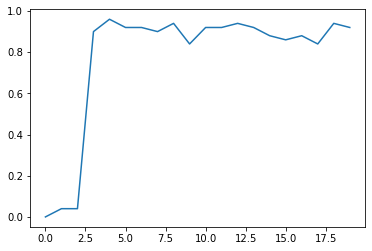

In [23]:
ac.show_reward()